In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from urllib.parse import urlsplit

Download Dataset

In [ ]:
links = ['http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
         'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
         'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
         'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
         'https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/configs/linear_config.yaml']

for link in links:
  filename = os.path.basename(urlsplit(link).path)
  # extracting the file name from the link
  if not os.path.exists(filename):
    !wget {link}

config = yaml.safe_load(open('linear_config.yaml'))
config['data_params']['data_path'] = '.'
print(config)

--2024-10-15 16:25:51--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.242, 3.5.136.94, 52.219.47.220, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.75.242|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  8.60MB/s    in 2.9s    

2024-10-15 16:25:54 (8.60 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-15 16:25:54--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.242, 3.5.136.94, 52.219.47.2

In [ ]:
class Linear_Classifier:

  def __init__(self, epochs, batch_size, lr, seed, classes, data_path):
    self.epochs = epochs
    self.batch_size = batch_size
    self.lr = lr
    self.seed = seed
    self.classes = classes
    self.data_path = data_path

  def load_mnist(self):
    import gzip

    """Load MNIST data from `path`"""
    train_labels_path = os.path.join(self.data_path,'train-labels-idx1-ubyte.gz')
    train_images_path = os.path.join(self.data_path,'train-images-idx3-ubyte.gz')

    test_labels_path = os.path.join(self.data_path,'t10k-labels-idx1-ubyte.gz')
    test_images_path = os.path.join(self.data_path,'t10k-images-idx3-ubyte.gz')

    with gzip.open(train_labels_path, 'rb') as lbpath:
        train_labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
        train_labels = np.eye(len(np.unique(train_labels)))[train_labels]

    with gzip.open(train_images_path, 'rb') as imgpath:
        train_images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(train_labels), 784)

    with gzip.open(test_labels_path, 'rb') as lbpath:
        test_labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
        test_labels = np.eye(len(np.unique(test_labels)))[test_labels]

    with gzip.open(test_images_path, 'rb') as imgpath:
        test_images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(test_labels), 784)

    self.X_train = train_images
    self.y_train = train_labels
    self.X_test = test_images
    self.y_test = test_labels


  def preprocess_images(self):
    X_train = self.X_train/255.0
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis = 0)
    X_train = (X_train - mean) / std

    X_test = self.X_test/255.0
    mean = np.mean(X_test, axis = 0)
    std = np.std(X_test, axis = 0)
    X_test = (X_test - mean) / std

    self.X_train = X_train
    self.X_test = X_test


  def data_splitter(self, train_ratio):

    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
        self.X_train, self.y_train, test_size = (1-train_ratio), random_state = self.seed, shuffle = True)

  def data_loader(self, train_ratio):

    self.load_mnist()
    self.preprocess_images()
    self.data_splitter(train_ratio)


  # Model functions
  def random_init(self, num_features, num_classes, seed):

    np.random.seed(self.seed)
    W = np.random.randn(num_features, num_classes) * 1e-5
    b = np.random.randn(num_classes) * 1e-3

    return W, b

  def softmax(self, logits):

    max_logits = np.max(logits, axis=-1, keepdims=True)
    exp_logits = np.exp(logits - max_logits)
    sum_exp_logits = np.sum(exp_logits, axis=-1, keepdims=True)
    softmax = exp_logits / sum_exp_logits

    return softmax

  def forward(self, X, W, b):

    return self.softmax((np.dot(X, W) + b))


  def cross_entropy_loss(self, y_batch, y_pred):

    # Clip the predictions to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    return -np.sum(y_batch * np.log(y_pred)) / y_batch.shape[0]


  def backward(self, X_batch, y_batch, y_pred):

    m = X_batch.shape[0]
    dW = (1 / m) * np.dot(X_batch.T, (y_pred - y_batch))
    db = (1 / m) * np.sum((y_pred - y_batch), axis=0)

    return dW, db

  def update(self, W, b, dW, db, lr):

    W -= lr * dW
    b -= lr * db

    return W, b


  def validate(self, X, y, W, b, batch_size):

    loss_val = 0
    predictions = []

    for i in range(0, X.shape[0], batch_size):

        X_batch = X[i : i + batch_size]
        y_batch = y[i : i + batch_size]

        y_pred = self.forward(X_batch, W, b)

        loss_ = self.cross_entropy_loss(y_batch, y_pred)
        loss_val += loss_

        predictions.append(y_pred)

    loss_val /= X.shape[0]
    y_pred = np.concatenate(predictions, axis=0)

    return loss_val, y_pred

  def train(self, num_classes):

    num_samples, num_features = self.X_train.shape

    W, b = self.random_init(num_features, num_classes, self.seed)
    loss = {"train": [],"val": []}

    for i in range(self.epochs):
      loss_epoch = 0

      loop = tqdm.tqdm(range(0, num_samples, self.batch_size), leave=False, ncols=100)

      for j in loop:

        # Creating batch size
        X_batch = self.X_train[j : j + self.batch_size]
        y_batch = self.y_train[j : j + self.batch_size]

        # Forward pass
        y_pred = self.forward(X_batch, W, b)

        # Calculate loss
        loss_ = self.cross_entropy_loss(y_batch, y_pred)
        loss_epoch += loss_

        # Backward pass
        dW, db = self.backward(X_batch, y_batch, y_pred)

        # Update weights and bias
        W, b = self.update(W, b, dW, db, self.lr)

        loop.set_description(f"Epoch [{i+1}/{self.epochs}]")
        loop.set_postfix(loss=loss_)

      loss["train"].append(loss_epoch/num_samples)

      # Validate
      loss_val, y_pred = self.validate(self.X_train, self.y_train, W, b, self.batch_size)
      loss["val"].append(loss_val)

    self.W = W
    self.b = b
    self.loss = loss


  # plot functions
  def plot(self):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(self.loss["train"], label="train")
    ax[0].plot(self.loss["val"], label="val")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[0].set_title("Training and Validation Loss")


    _, y_pred = self.validate(self.X_test, self.y_test, self.W, self.b, self.batch_size)
    y_pred = np.argmax(y_pred, axis=1)

    self.y_pred = y_pred
    self.y_test = np.argmax(self.y_test, axis=1)
    self.f1 = round(f1_score(self.y_test, self.y_pred, average='macro'), 2)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(self.y_test, y_pred), display_labels=self.classes)
    disp = disp.plot(ax=ax[1], xticks_rotation=45)
    title = 'Confusion Matrix, batch size:' + str(self.batch_size) + ', lr: ' + str(self.lr)
    ax[1].set_title(title)

    plt.tight_layout()
    plt.show()

    print('\n\n')
    print(classification_report(self.y_test, y_pred, target_names=self.classes))

  def weight_visual(self):

    fig, axes = plt.subplots(2, len(self.classes)//2, figsize=(20, 10))
    for i, class_name in enumerate(self.classes):
        row, col = i // 5, i % 5
        img = self.W[:, i].reshape(28, 28)
        img = (img - img.min()) / (img.max() - img.min())
        img = (img * 255).astype("uint8")
        axes[row, col].imshow(img)
        axes[row, col].set_title(class_name)
        axes[row, col].axis('off')
    plt.show()

In [ ]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

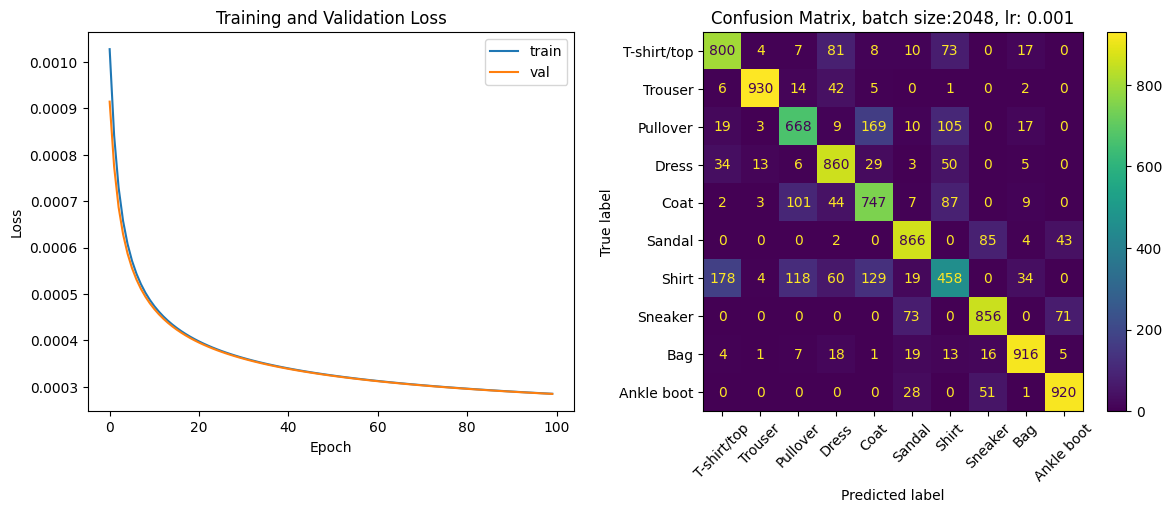




              precision    recall  f1-score   support

 T-shirt/top       0.77      0.80      0.78      1000
     Trouser       0.97      0.93      0.95      1000
    Pullover       0.73      0.67      0.70      1000
       Dress       0.77      0.86      0.81      1000
        Coat       0.69      0.75      0.72      1000
      Sandal       0.84      0.87      0.85      1000
       Shirt       0.58      0.46      0.51      1000
     Sneaker       0.85      0.86      0.85      1000
         Bag       0.91      0.92      0.91      1000
  Ankle boot       0.89      0.92      0.90      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [ ]:
'''
epochs, batch_size, lr, seed

e1 = batch = 2048, lr = .001
e2 = batch = 1024, lr = .001
e3 = batch = 512, lr = .001
e4 = batch = 2048, lr = .0001
e5 = batch = 1024, lr = .0001
e6 = batch = 512, lr = .0001
'''

e1 = Linear_Classifier(100, 2048, 0.001, 42, classes, '.')
e1.data_loader(config['data_params']['train_ratio'])
e1.train(len(classes))
e1.plot()

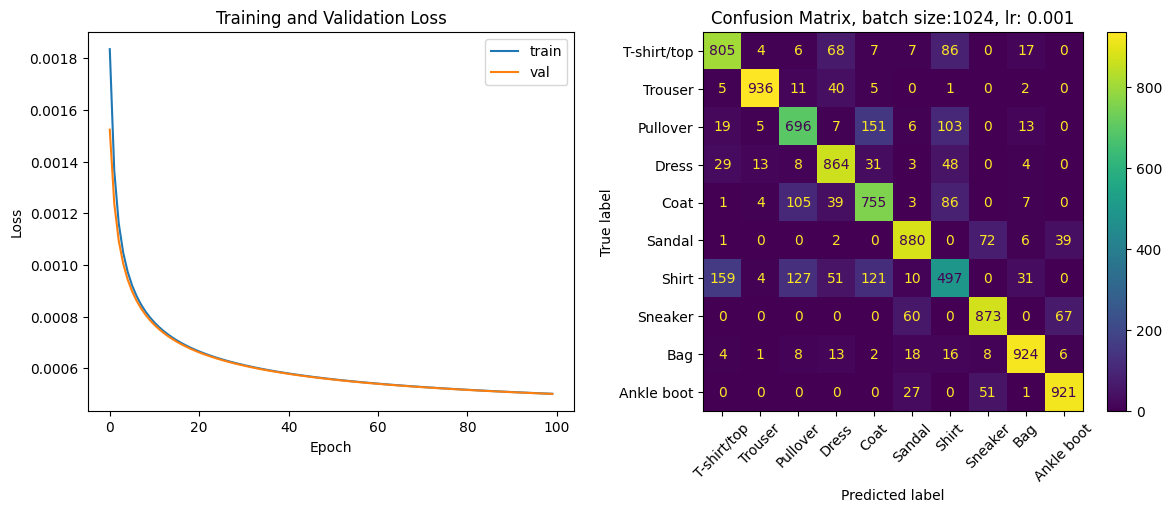




              precision    recall  f1-score   support

 T-shirt/top       0.79      0.81      0.80      1000
     Trouser       0.97      0.94      0.95      1000
    Pullover       0.72      0.70      0.71      1000
       Dress       0.80      0.86      0.83      1000
        Coat       0.70      0.76      0.73      1000
      Sandal       0.87      0.88      0.87      1000
       Shirt       0.59      0.50      0.54      1000
     Sneaker       0.87      0.87      0.87      1000
         Bag       0.92      0.92      0.92      1000
  Ankle boot       0.89      0.92      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.81      0.82      0.81     10000
weighted avg       0.81      0.82      0.81     10000



In [ ]:
'''
epochs, batch_size, lr, seed

e1 = batch = 2048, lr = .001
e2 = batch = 1024, lr = .001
e3 = batch = 512, lr = .001
e4 = batch = 2048, lr = .0001
e5 = batch = 1024, lr = .0001
e6 = batch = 512, lr = .0001
'''

e2 = Linear_Classifier(100, 1024, 0.001, 42, classes, '.')
e2.data_loader(config['data_params']['train_ratio'])
e2.train(len(classes))
e2.plot()

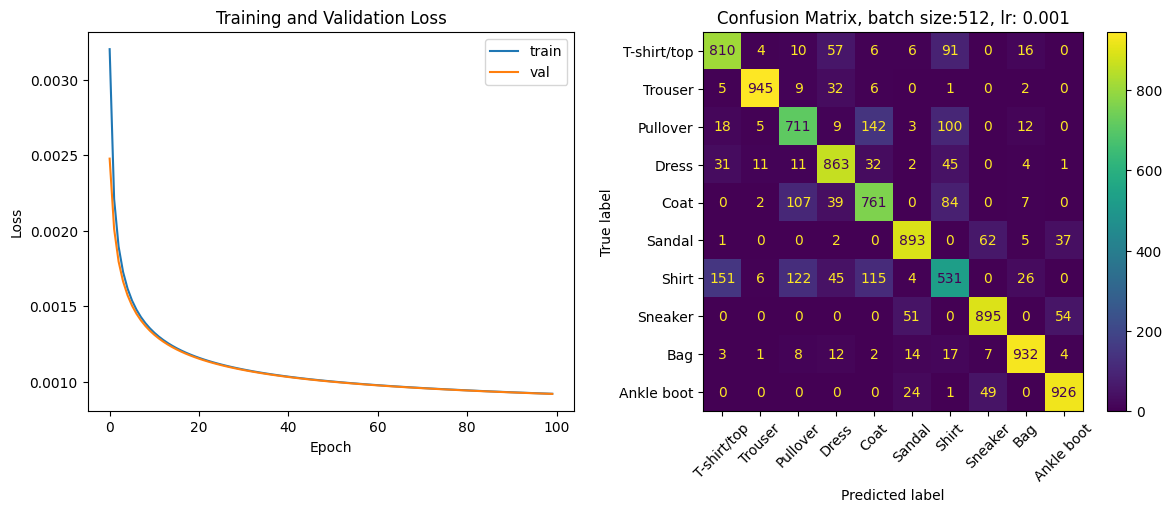




              precision    recall  f1-score   support

 T-shirt/top       0.79      0.81      0.80      1000
     Trouser       0.97      0.94      0.96      1000
    Pullover       0.73      0.71      0.72      1000
       Dress       0.81      0.86      0.84      1000
        Coat       0.72      0.76      0.74      1000
      Sandal       0.90      0.89      0.89      1000
       Shirt       0.61      0.53      0.57      1000
     Sneaker       0.88      0.90      0.89      1000
         Bag       0.93      0.93      0.93      1000
  Ankle boot       0.91      0.93      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.82      0.83      0.83     10000
weighted avg       0.82      0.83      0.83     10000



In [ ]:
'''
epochs, batch_size, lr, seed

e1 = batch = 2048, lr = .001
e2 = batch = 1024, lr = .001
e3 = batch = 512, lr = .001
e4 = batch = 2048, lr = .0001
e5 = batch = 1024, lr = .0001
e6 = batch = 512, lr = .0001
'''

e3 = Linear_Classifier(100, 512, 0.001, 42, classes, '.')
e3.data_loader(config['data_params']['train_ratio'])
e3.train(len(classes))
e3.plot()

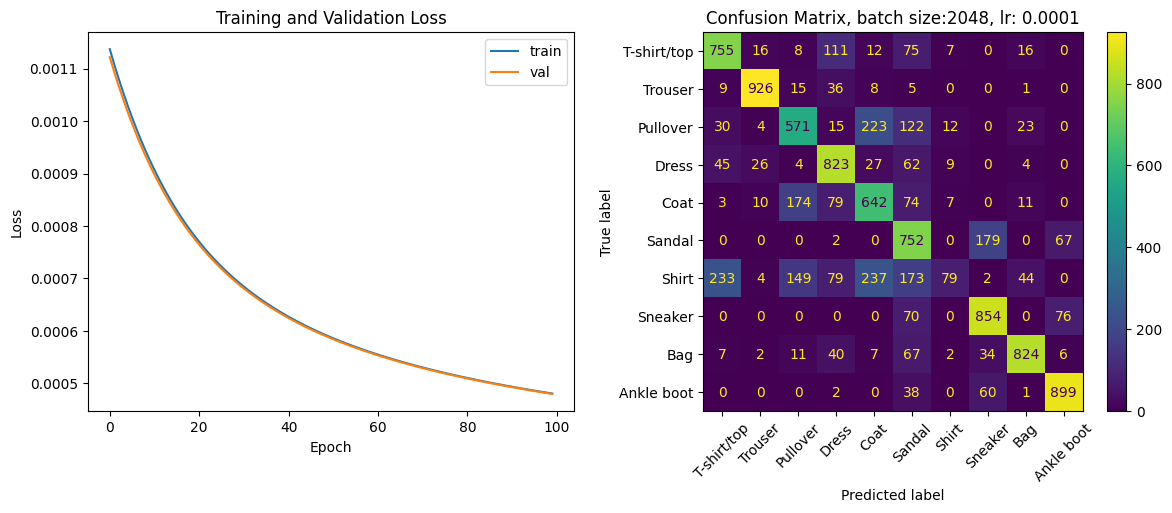




              precision    recall  f1-score   support

 T-shirt/top       0.70      0.76      0.73      1000
     Trouser       0.94      0.93      0.93      1000
    Pullover       0.61      0.57      0.59      1000
       Dress       0.69      0.82      0.75      1000
        Coat       0.56      0.64      0.60      1000
      Sandal       0.52      0.75      0.62      1000
       Shirt       0.68      0.08      0.14      1000
     Sneaker       0.76      0.85      0.80      1000
         Bag       0.89      0.82      0.86      1000
  Ankle boot       0.86      0.90      0.88      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.69     10000
weighted avg       0.72      0.71      0.69     10000



In [ ]:
'''
epochs, batch_size, lr, seed

e1 = batch = 2048, lr = .001
e2 = batch = 1024, lr = .001
e3 = batch = 512, lr = .001
e4 = batch = 2048, lr = .0001
e5 = batch = 1024, lr = .0001
e6 = batch = 512, lr = .0001
'''

e4 = Linear_Classifier(100, 2048, 0.0001, 42, classes, '.')
e4.data_loader(config['data_params']['train_ratio'])
e4.train(len(classes))
e4.plot()

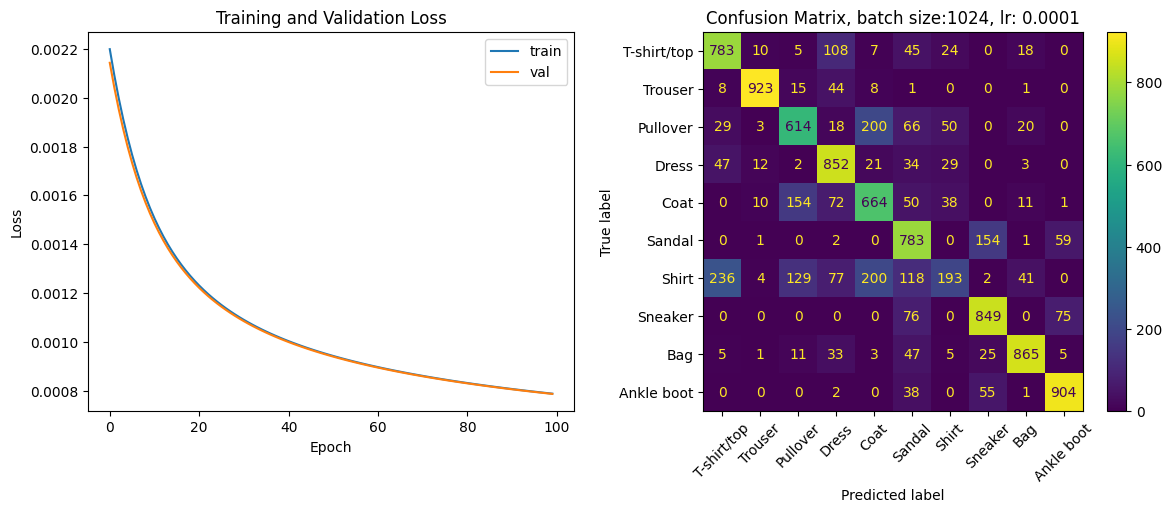




              precision    recall  f1-score   support

 T-shirt/top       0.71      0.78      0.74      1000
     Trouser       0.96      0.92      0.94      1000
    Pullover       0.66      0.61      0.64      1000
       Dress       0.71      0.85      0.77      1000
        Coat       0.60      0.66      0.63      1000
      Sandal       0.62      0.78      0.69      1000
       Shirt       0.57      0.19      0.29      1000
     Sneaker       0.78      0.85      0.81      1000
         Bag       0.90      0.86      0.88      1000
  Ankle boot       0.87      0.90      0.88      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.73     10000
weighted avg       0.74      0.74      0.73     10000



In [ ]:
'''
epochs, batch_size, lr, seed

e1 = batch = 2048, lr = .001
e2 = batch = 1024, lr = .001
e3 = batch = 512, lr = .001
e4 = batch = 2048, lr = .0001
e5 = batch = 1024, lr = .0001
e6 = batch = 512, lr = .0001
'''

e5 = Linear_Classifier(100, 1024, 0.0001, 42, classes, '.')
e5.data_loader(config['data_params']['train_ratio'])
e5.train(len(classes))
e5.plot()

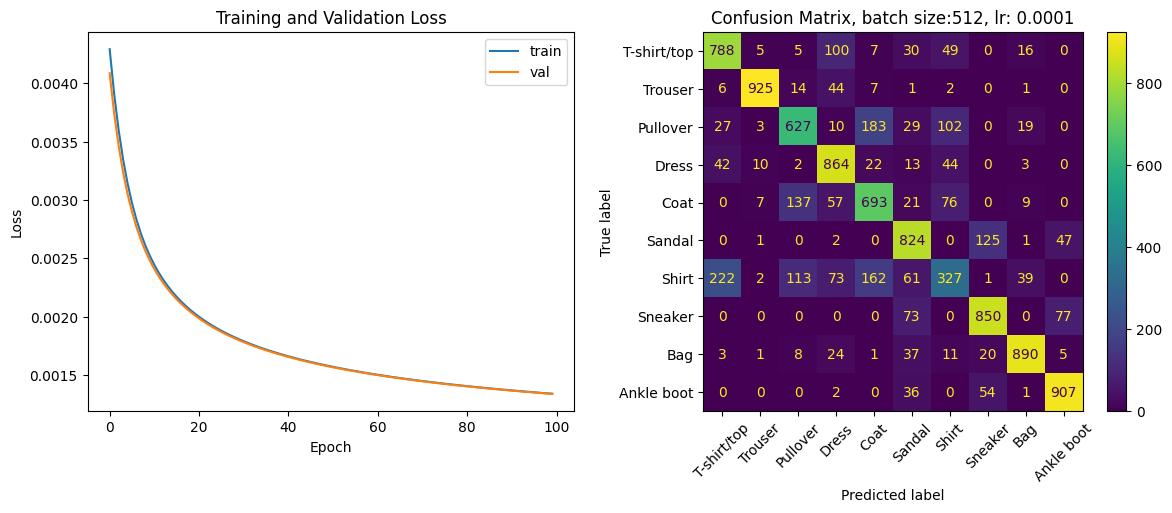




              precision    recall  f1-score   support

 T-shirt/top       0.72      0.79      0.75      1000
     Trouser       0.97      0.93      0.95      1000
    Pullover       0.69      0.63      0.66      1000
       Dress       0.73      0.86      0.79      1000
        Coat       0.64      0.69      0.67      1000
      Sandal       0.73      0.82      0.78      1000
       Shirt       0.54      0.33      0.41      1000
     Sneaker       0.81      0.85      0.83      1000
         Bag       0.91      0.89      0.90      1000
  Ankle boot       0.88      0.91      0.89      1000

    accuracy                           0.77     10000
   macro avg       0.76      0.77      0.76     10000
weighted avg       0.76      0.77      0.76     10000



In [ ]:
'''
epochs, batch_size, lr, seed

e1 = batch = 2048, lr = .001
e2 = batch = 1024, lr = .001
e3 = batch = 512, lr = .001
e4 = batch = 2048, lr = .0001
e5 = batch = 1024, lr = .0001
e6 = batch = 512, lr = .0001
'''

e6 = Linear_Classifier(100, 512, 0.0001, 42, classes, '.')
e6.data_loader(config['data_params']['train_ratio'])
e6.train(len(classes))
e6.plot()

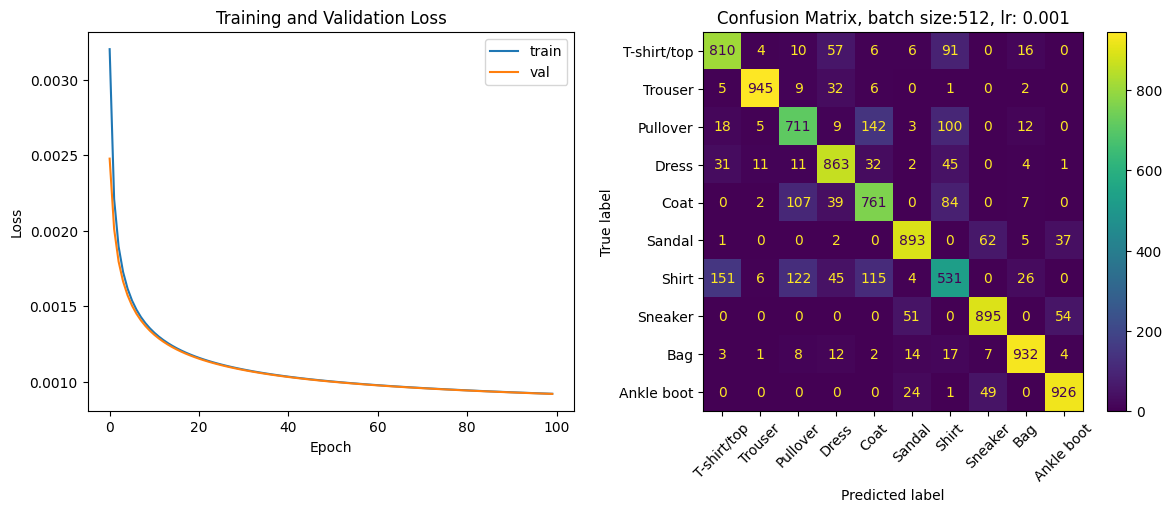




              precision    recall  f1-score   support

 T-shirt/top       0.79      0.81      0.80      1000
     Trouser       0.97      0.94      0.96      1000
    Pullover       0.73      0.71      0.72      1000
       Dress       0.81      0.86      0.84      1000
        Coat       0.72      0.76      0.74      1000
      Sandal       0.90      0.89      0.89      1000
       Shirt       0.61      0.53      0.57      1000
     Sneaker       0.88      0.90      0.89      1000
         Bag       0.93      0.93      0.93      1000
  Ankle boot       0.91      0.93      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.82      0.83      0.83     10000
weighted avg       0.82      0.83      0.83     10000



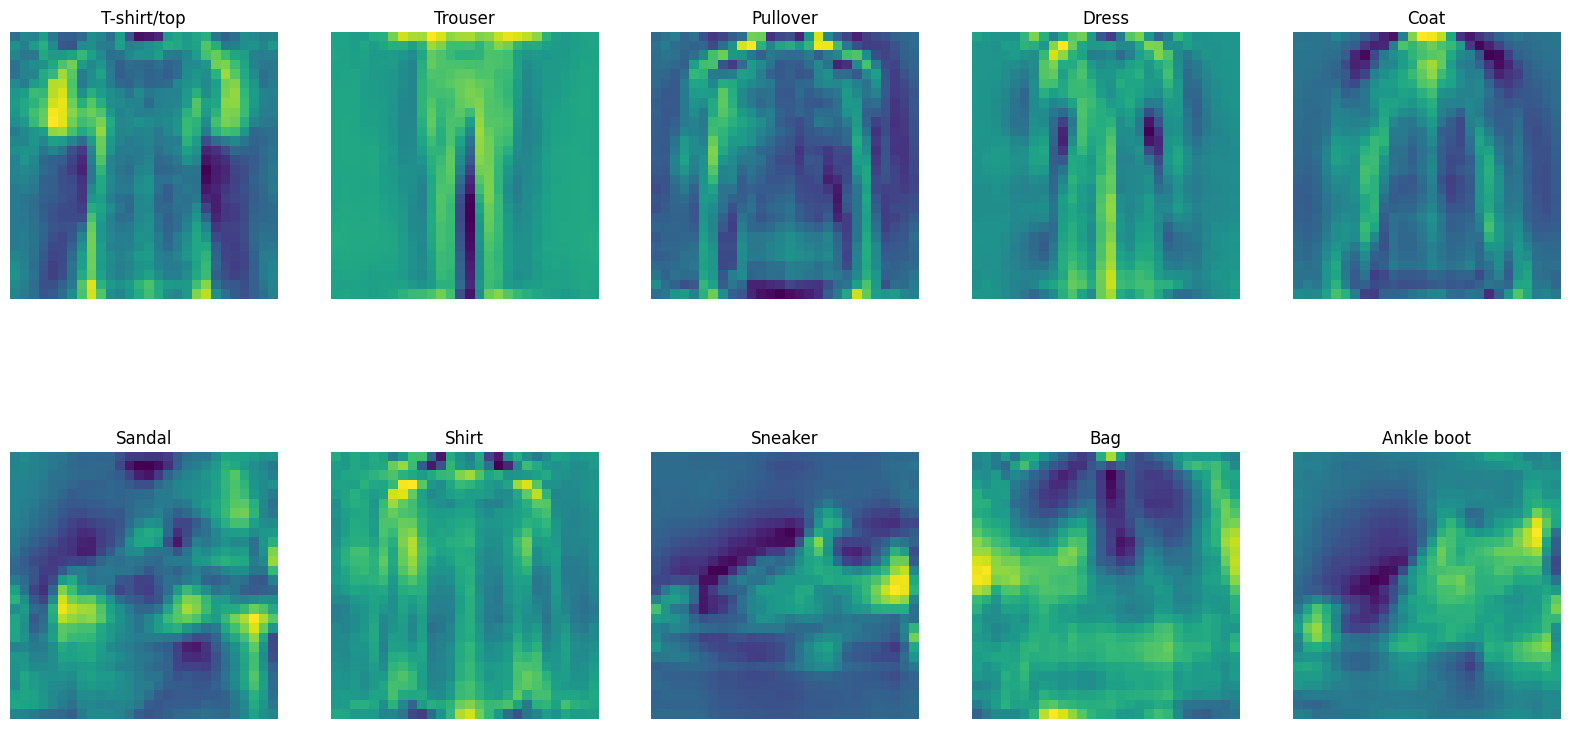

In [ ]:
# best batch_size - 512, lr = 0.001
'''
epochs, batch_size, lr, seed

e1 = batch = 2048, lr = .001
e2 = batch = 1024, lr = .001
e3 = batch = 512, lr = .001
e4 = batch = 2048, lr = .0001
e5 = batch = 1024, lr = .0001
e6 = batch = 512, lr = .0001
'''

e3 = Linear_Classifier(100, 512, 0.001, 42, classes, '.')
e3.data_loader(config['data_params']['train_ratio'])
e3.train(len(classes))
e3.plot()
e3.weight_visual()